In [2]:
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import time
from matplotlib import pyplot as plt

# Ensure TensorFlow 2.x is being used
assert tf.__version__.startswith('2.') # Use __version__ instead of _version_

# Parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
num_classes = 10

# Seed for visualizing progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_labels = np.random.randint(0, num_classes, num_examples_to_generate)

# CIFAR-10 specific parameters
BUFFER_SIZE = 50000
BATCH_SIZE = 256
IMAGE_SIZE = 32
CHANNELS = 3

In [3]:
def build_generator():
    noise = layers.Input(shape=(noise_dim,))
    label = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(num_classes, noise_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    model_input = layers.multiply([noise, label_embedding])

    x = layers.Dense(8*8*256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 256))(x)
    assert x.shape == (None, 8, 8, 256)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    assert x.shape == (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

    return tf.keras.Model([noise, label], x)

In [4]:
def build_discriminator():
    image = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    label = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(num_classes, IMAGE_SIZE * IMAGE_SIZE * CHANNELS)(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((IMAGE_SIZE, IMAGE_SIZE, CHANNELS))(label_embedding)

    model_input = layers.concatenate([image, label_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(model_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return tf.keras.Model([image, label], x)

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [6]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    generated_labels = tf.random.uniform([BATCH_SIZE], minval=0, maxval=num_classes, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, generated_labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, generated_labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)

        # Produce images for the GIF as we go
        clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed, seed_labels)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, seed_labels)

In [7]:
def generate_and_save_images(model, epoch, test_input, labels):
    predictions = model([test_input, labels], training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Rescale to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [8]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 [==============================] - 3s 0us/step


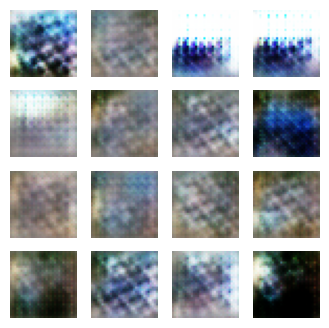

In [10]:
train(train_dataset, EPOCHS)